# Testing Our Models #

We will test the stability of the solutions returned by each model by running 100 randomly generated tests for each model type.

In [1]:
from biglittlematcher import BigLittleMatcher
import random

This will be our general function for testing stability.

In [2]:
def test_stability(generator_func, build_model=None, num_tests=100):
    stable_count = 0
    unstable_count = 0
    
    for _ in range(num_tests):
        if build_model:
            bigs, littles, big_prefs, little_prefs, model_builder = generator_func(build_model)
        else:
            bigs, littles, big_prefs, little_prefs, model_builder = generator_func()
        
        try:
            matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
            model_builder(matcher)
            matches, _ = matcher.solve()
            instabilities = matcher.check_instabilities(matches)
            
            if len(instabilities) == 0:
                stable_count += 1
            else:
                unstable_count += 1
        except Exception as e:
            unstable_count += 1
    
    return stable_count, unstable_count

First, we will test all the models with the standard stable marriage problem.

In [3]:
def generate_sm_test(build_model_func="build_model"):
    size = random.randint(3, 6)
    bigs = {f"B{i}": {} for i in range(1, size+1)}
    littles = {f"L{i}": {} for i in range(1, size+1)}
    
    big_prefs = {}
    little_prefs = {}
    
    # Choose format based on which build model we're using
    for b in bigs:
        if build_model_func == "build_model":
            big_prefs[b] = random.sample(list(littles.keys()), len(littles))
        else:
            littles_list = random.sample(list(littles.keys()), len(littles))
            big_prefs[b] = {littles_list[i]: i+1 for i in range(len(littles_list))}

    for l in littles:
        if build_model_func == "build_model":
            little_prefs[l] = random.sample(list(bigs.keys()), len(bigs))
        else:
            bigs_list = random.sample(list(bigs.keys()), len(bigs))
            little_prefs[l] = {bigs_list[i]: i+1 for i in range(len(bigs_list))}
    
    model_builder = None
    if build_model_func == "build_model":
        model_builder = lambda m: m.build_model()
    elif build_model_func == "build_model_smt":
        model_builder = lambda m: m.build_model_smt()
    elif build_model_func == "build_model_smti":
        model_builder = lambda m: m.build_model_smti()
    
    return bigs, littles, big_prefs, little_prefs, model_builder

### Testing Our Constraints Model vs. Gale-Shapley ###

First, we want to see how our constraints model compares to Gale-Shapley. We will generate random preferences and then test how long it takes for each model to solve the problem. Should expect our constraints model to be slower than Gale-Shapley because GS is an efficient algorithm that focuses specifically on solving this problem whereas our constraints model is a more general model that can solve other problems.

Running test case for size 5, iteration 1/10
Running test case for size 5, iteration 2/10
Running test case for size 5, iteration 3/10
Running test case for size 5, iteration 4/10
Running test case for size 5, iteration 5/10
Running test case for size 5, iteration 6/10
Running test case for size 5, iteration 7/10
Running test case for size 5, iteration 8/10
Running test case for size 5, iteration 9/10
Running test case for size 5, iteration 10/10
Running test case for size 10, iteration 1/10
Running test case for size 10, iteration 2/10
Running test case for size 10, iteration 3/10
Running test case for size 10, iteration 4/10
Running test case for size 10, iteration 5/10
Running test case for size 10, iteration 6/10
Running test case for size 10, iteration 7/10
Running test case for size 10, iteration 8/10
Running test case for size 10, iteration 9/10
Running test case for size 10, iteration 10/10
Running test case for size 15, iteration 1/10
Running test case for size 15, iteration 2

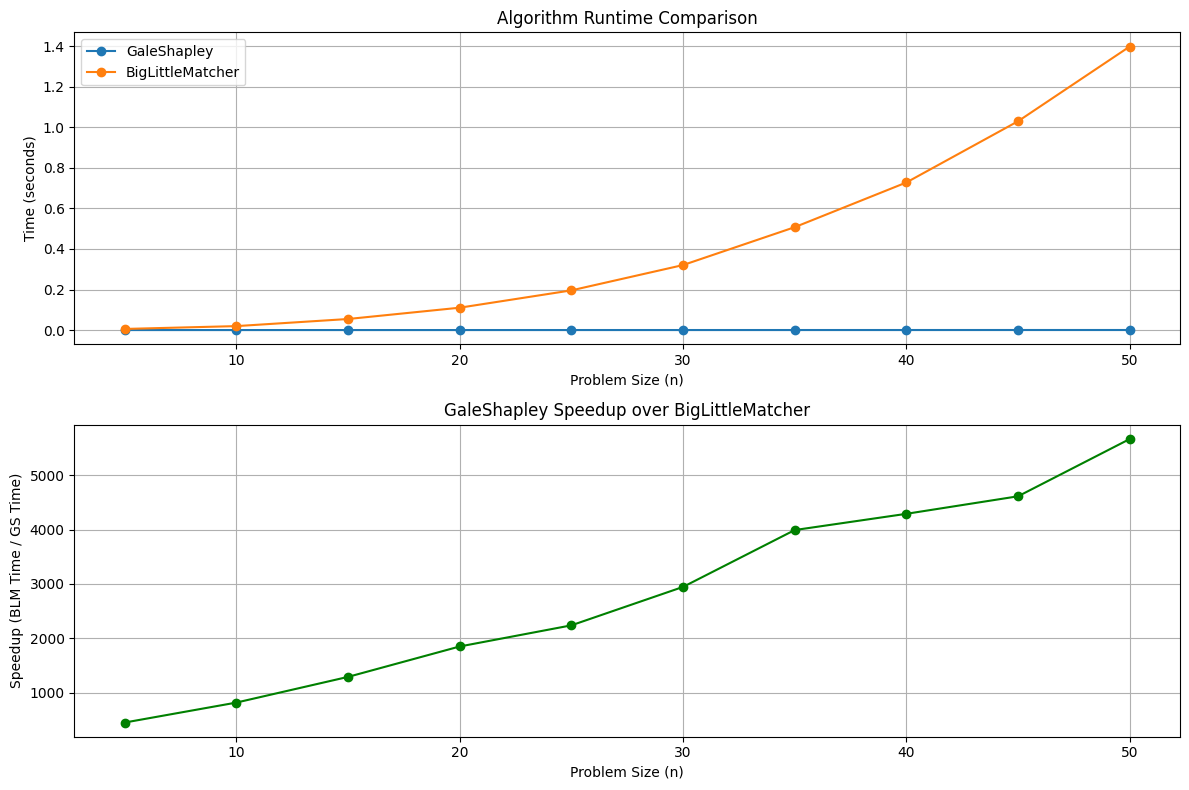

Results saved to comparison_results.png


In [8]:
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from galeshapely import GaleShapley
from biglittlematcher import BigLittleMatcher

def generate_random_preferences(n_bigs, n_littles):
    """Generate random preferences for bigs and littles."""
    bigs = {f'B{i}': {} for i in range(n_bigs)}
    littles = {f'L{i}': {} for i in range(n_littles)}
    
    # Generate big preferences (list format for GaleShapley)
    big_prefs_list = {}
    for b in bigs:
        big_prefs_list[b] = random.sample([f'L{i}' for i in range(n_littles)], n_littles)
    
    # Generate little preferences (list format for GaleShapley)
    little_prefs_list = {}
    for l in littles:
        little_prefs_list[l] = random.sample([f'B{i}' for i in range(n_bigs)], n_bigs)
    
    # Convert to dictionary format for BigLittleMatcher
    big_prefs_dict = {}
    for b in bigs:
        big_prefs_dict[b] = []
        for l in big_prefs_list[b]:
            big_prefs_dict[b].append(l)
    
    little_prefs_dict = {}
    for l in littles:
        little_prefs_dict[l] = []
        for b in little_prefs_list[l]:
            little_prefs_dict[l].append(b)
    
    return bigs, littles, big_prefs_list, little_prefs_list, big_prefs_dict, little_prefs_dict

def run_gale_shapley(big_prefs, little_prefs):
    """Run the GaleShapley algorithm and time it."""
    start_time = time.time()
    gs = GaleShapley(big_prefs, little_prefs)
    matches = gs.match()
    end_time = time.time()
    return end_time - start_time, matches

def run_big_little_matcher(bigs, littles, big_prefs, little_prefs):
    """Run the BigLittleMatcher algorithm and time it."""
    start_time = time.time()
    blm = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
    blm.build_model()
    matches, _ = blm.solve()
    end_time = time.time()
    return end_time - start_time, matches

def verify_matching_stability(matches_gs, big_prefs, little_prefs):
    """Verify that the matching is stable."""
    # Handle different formats of matches
    if isinstance(matches_gs, dict):
        # If it's a dictionary, convert to list of tuples
        matches_list = [(b, l) for b, l in matches_gs.items()]
    else:
        # If it's already a list of tuples
        matches_list = matches_gs
    
    # Create the mappings
    big_to_little = {b: l for b, l in matches_list}
    little_to_big = {l: b for b, l in matches_list}
    
    # Check for blocking pairs
    for b in big_prefs:
        for l in big_prefs[b]:
            if big_to_little.get(b) == l:  # Skip their match
                continue
                
            # If either is unmatched, no blocking pair possible
            if b not in big_to_little or l not in little_to_big:
                continue
                
            # Get current matches
            b_matched_l = big_to_little[b]
            l_matched_b = little_to_big[l]
            
            # Check preferences
            b_prefers_l = big_prefs[b].index(l) < big_prefs[b].index(b_matched_l)
            l_prefers_b = little_prefs[l].index(b) < little_prefs[l].index(l_matched_b)
            
            if b_prefers_l and l_prefers_b:
                return False  # Found a blocking pair
    
    return True

# Results storage
results = {
    'size': [],
    'gale_shapley_time': [],
    'big_little_matcher_time': [],
    'speedup': []
}

# Test cases with different sizes
sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
iterations_per_size = 10  # 10 iterations per size = 100 total test cases

for size in sizes:
    for i in range(iterations_per_size):
        print(f"Running test case for size {size}, iteration {i+1}/{iterations_per_size}")
        
        # Generate random preferences
        bigs, littles, big_prefs_list, little_prefs_list, big_prefs_dict, little_prefs_dict = generate_random_preferences(size, size)
        
        # Run GaleShapley
        gs_time, gs_matches = run_gale_shapley(big_prefs_list, little_prefs_list)
        
        # Run BigLittleMatcher
        blm_time, blm_matches = run_big_little_matcher(bigs, littles, big_prefs_dict, little_prefs_dict)
        
        # Verify stability of GaleShapley matching
        is_stable = verify_matching_stability(gs_matches, big_prefs_list, little_prefs_list)
        if not is_stable:
            print(f"Warning: GaleShapley produced unstable matching for size {size}, iteration {i}")
        
        # Store results
        results['size'].append(size)
        results['gale_shapley_time'].append(gs_time)
        results['big_little_matcher_time'].append(blm_time)
        results['speedup'].append(blm_time / gs_time)

# Convert to DataFrame for analysis
df = pd.DataFrame(results)

# Group by size and calculate averages
avg_results = df.groupby('size').mean().reset_index()

# Print results
print("\nAverage Results by Size:")
print(avg_results)

# Plot results
plt.figure(figsize=(12, 8))

# Time comparison
plt.subplot(2, 1, 1)
plt.plot(avg_results['size'], avg_results['gale_shapley_time'], 'o-', label='GaleShapley')
plt.plot(avg_results['size'], avg_results['big_little_matcher_time'], 'o-', label='BigLittleMatcher')
plt.xlabel('Problem Size (n)')
plt.ylabel('Time (seconds)')
plt.title('Algorithm Runtime Comparison')
plt.legend()
plt.grid(True)

# Speedup
plt.subplot(2, 1, 2)
plt.plot(avg_results['size'], avg_results['speedup'], 'o-', color='green')
plt.xlabel('Problem Size (n)')
plt.ylabel('Speedup (BLM Time / GS Time)')
plt.title('GaleShapley Speedup over BigLittleMatcher')
plt.grid(True)

plt.tight_layout()
plt.show()

### Standard Matching (Original) Test Results ###

The results here look good because all models should be able to solve the standard matching problem. Since SMT and SMTI are both supersets of the original model.

In [ ]:
# Run 100 tests for each model type
print("Testing Standard Stable Matching with build_model:")
sm_stable, sm_unstable = test_stability(generate_sm_test, "build_model")
print(f"Stable: {sm_stable}, Unstable: {sm_unstable}")

print("Testing Standard Stable Matching with build_model_smt:")
sm_stable2, sm_unstable2 = test_stability(generate_sm_test, "build_model_smt")
print(f"Stable: {sm_stable2}, Unstable: {sm_unstable2}")

print("Testing Standard Stable Matching with build_model_smti:")
sm_stable2, sm_unstable2 = test_stability(generate_sm_test, "build_model_smti")
print(f"Stable: {sm_stable2}, Unstable: {sm_unstable2}")

Then, we will test the models with the stable matching with ties problem.

In [5]:
def generate_smt_test(build_model_func="build_model_smt"):
    size = random.randint(3, 6)
    bigs = {f"B{i}": {} for i in range(1, size+1)}
    littles = {f"L{i}": {} for i in range(1, size+1)}
    
    # Generate preferences with ties
    big_prefs = {}
    little_prefs = {}
    
    for b in bigs:
        # Complete list but with possible ties
        ranks = {}
        little_list = list(littles.keys())
        random.shuffle(little_list)
        
        current_rank = 1
        for l in little_list:
            # 30% chance of keeping the same rank (making a tie)
            if random.random() > 0.3 and l != little_list[0]:
                current_rank += 1
            ranks[l] = current_rank
        big_prefs[b] = ranks
    
    for l in littles:
        ranks = {}
        big_list = list(bigs.keys())
        random.shuffle(big_list)
        
        current_rank = 1
        for b in big_list:
            # 30% chance of keeping the same rank (making a tie)
            if random.random() > 0.3 and b != big_list[0]:
                current_rank += 1
            ranks[b] = current_rank
        little_prefs[l] = ranks
    
    # Map string name to actual method call
    model_builder = None
    if build_model_func == "build_model_smt":
        model_builder = lambda m: m.build_model_smt()
    elif build_model_func == "build_model_smti":
        model_builder = lambda m: m.build_model_smti()
    
    return bigs, littles, big_prefs, little_prefs, model_builder

### Stable Matching with Ties Test Results ###

The results here look good because SMT and SMTI both solve the stable matching with ties problem. This additionally looks good because SMTI is a superset of SMT.

In [ ]:

print("\nTesting Stable Matching with Ties using build_model_smt:")
smt_stable, smt_unstable = test_stability(generate_smt_test, "build_model_smt")
print(f"Stable: {smt_stable}, Unstable: {smt_unstable}")

print("\nTesting Stable Matching with Ties using build_model_smti:")
smt_stable2, smt_unstable2 = test_stability(generate_smt_test, "build_model_smti")
print(f"Stable: {smt_stable2}, Unstable: {smt_unstable2}")

Finally, we will test the models with the stable matching with ties and incomplete lists problem.

In [7]:
def generate_smti_test():
    """Generate a Stable Marriage with Ties and Incomplete Lists test case"""
    size = random.randint(3, 6)
    bigs = {f"B{i}": {} for i in range(1, size+1)}
    littles = {f"L{i}": {} for i in range(1, size+1)}
    
    # Generate preferences with ties and incomplete lists
    big_prefs = {}
    little_prefs = {}
    
    for b in bigs:
        # Each big ranks a random subset of littles
        num_to_rank = random.randint(1, len(littles))
        selected_littles = random.sample(list(littles.keys()), num_to_rank)
        
        ranks = {}
        current_rank = 1
        for l in selected_littles:
            # 30% chance of keeping the same rank (making a tie)
            if random.random() > 0.3 and l != selected_littles[0]:
                current_rank += 1
            ranks[l] = current_rank
        big_prefs[b] = ranks
    
    for l in littles:
        # Each little ranks a random subset of bigs
        num_to_rank = random.randint(1, len(bigs))
        selected_bigs = random.sample(list(bigs.keys()), num_to_rank)
        
        ranks = {}
        current_rank = 1
        for b in selected_bigs:
            # 30% chance of keeping the same rank (making a tie)
            if random.random() > 0.3 and b != selected_bigs[0]:
                current_rank += 1
            ranks[b] = current_rank
        little_prefs[l] = ranks
    
    return bigs, littles, big_prefs, little_prefs, lambda m: m.build_model_smti()

### Stable Matching with Ties and Incomplete Lists Test Results ###

The results here look good because SMTI solver solves the stable matching with ties and incomplete lists problem.

In [ ]:
print("\nTesting Stable Matching with Ties and Incomplete Lists:")
smti_stable, smti_unstable = test_stability(generate_smti_test)
print(f"Stable: {smti_stable}, Unstable: {smti_unstable}")